## 一、导入相关模块

In [15]:
import warnings
warnings.filterwarnings("ignore")
from nilmtk.api import API
from nilmtk.disaggregate import Mean
from nilmtk_contrib.disaggregate import DAE,Seq2Point, Seq2Seq, RNN, WindowGRU,DSC
from nilmtk.disaggregate import FHMMExact,CO

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
from collections import OrderedDict
from nilmtk.dataset import DataSet
from tensorflow.keras.layers import Conv1D, Dense, Bidirectional, LSTM,Dropout,Flatten,MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import backend as K

## 二、设置参数

In [49]:
#数据初始化
path='ukdale.h5'
building=1
time={
    'train':{
    'start_time':'2013-3-18',
    'end_time':'2013-5-18'
    },
    'test':{
        'start_time':'2013-5-18',
        'end_time': '2013-6-18'
    }
     }
appliances=['dish washer','washer dryer','microwave','kettle','fridge']#,'washer dryer','dish washer','kettle','fridge'
appliances_param={
            'kettle':{'sequence_length':125,'batch_size':1024,'threshold':2000},
            'microwave':{'sequence_length':63,'batch_size':1024,'threshold':200},##负荷分解时sequence_length为125，负荷识别为63
            'washer dryer':{'sequence_length':255,'batch_size':1024,'threshold':20},
            'dish washer':{'sequence_length':255,'batch_size':1024,'threshold':10},
            'fridge':{'sequence_length':99,'batch_size':1024,'threshold':50},
            }
sample_period=6
artificial_aggregate=False
mains_mean=1800
mains_std=600
sequence_length=125
batch_size=32
model_name="CNN_LSTM"
file_prefix = "{}".format(model_name)
model_path='5-20-负荷识别'

## *定义相关函数

In [33]:
#函数定义
def dropna(mains_df, appliance_dfs=[]):#去除nan值
    """
    Drops the missing values in the Mains reading and appliance readings and returns consistent data by copmuting the intersection
    """
    print ("Dropping missing values")

    # The below steps are for making sure that data is consistent by doing intersection across appliances
    mains_df = mains_df.dropna()
    ix = mains_df.index
    mains_df = mains_df.loc[ix]
    for i in range(len(appliance_dfs)):
        appliance_dfs[i] = appliance_dfs[i].dropna()

    for  app_df in appliance_dfs:
        ix = ix.intersection(app_df.index)
    mains_df = mains_df.loc[ix]
    new_appliances_list = []
    for app_df in appliance_dfs:
        new_appliances_list.append(app_df.loc[ix])
    return mains_df,new_appliances_list

def call_preprocessing(mains_lst, submeters_lst, method,appliance_params,sequence_length):#数据预处理：归一化 
    if method == 'train':
        mains_df_list = []
        for mains in mains_lst:
            new_mains = mains.values.flatten()
            n = sequence_length
            units_to_pad = n // 2
            new_mains = np.pad(new_mains,(units_to_pad,units_to_pad),'constant',constant_values=(0,0))
            new_mains = np.array([new_mains[i:i + n] for i in range(len(new_mains) - n + 1)])
            new_mains = (new_mains - mains_mean) / mains_std
            mains_df_list.append(pd.DataFrame(new_mains))

        appliance_list = []
        for app_index, (app_name, app_df_list) in enumerate(submeters_lst):
            if app_name in appliance_params:
                app_mean = appliance_params[app_name]['mean']
                app_std = appliance_params[app_name]['std']
            else:
                print ("Parameters for ", app_name ," were not found!")
                raise ApplianceNotFoundError()

            processed_appliance_dfs = []

            for app_df in app_df_list:
                new_app_readings = app_df.values.reshape((-1, 1))
                # This is for choosing windows
                new_app_readings = (new_app_readings - app_mean) / app_std  
                # Return as a list of dataframe
                processed_appliance_dfs.append(pd.DataFrame(new_app_readings))
            appliance_list.append((app_name, processed_appliance_dfs))
        return mains_df_list, appliance_list

    if method == 'train_state':
        mains_df_list = []
        for mains in mains_lst:
            new_mains = mains.values.flatten()
            n = sequence_length
            units_to_pad = n // 2
            new_mains = np.pad(new_mains,(units_to_pad,units_to_pad),'constant',constant_values=(0,0))
            new_mains = np.array([new_mains[i:i + n] for i in range(len(new_mains) - n + 1)])
            new_mains = (new_mains - mains_mean) / mains_std
            mains_df_list.append(pd.DataFrame(new_mains))
            
        appliance_list = []
        for app_index, (app_name, app_df_list) in enumerate(submeters_lst):
            if app_name in appliance_params:
                app_mean = appliance_params[app_name]['mean']
                app_std = appliance_params[app_name]['std']
            else:
                print ("Parameters for ", app_name ," were not found!")
                raise ApplianceNotFoundError()

            processed_appliance_dfs = []

            for app_df in app_df_list:
                new_app_readings = app_df.values.reshape((-1, 1))
                processed_appliance_dfs.append(pd.DataFrame(new_app_readings))
            appliance_list.append((app_name, processed_appliance_dfs))
        return mains_df_list, appliance_list
    
    else:
        mains_df_list = []

        for mains in mains_lst:
            new_mains = mains.values.flatten()
            n = sequence_length
            units_to_pad = n // 2
            new_mains = np.pad(new_mains,(units_to_pad,units_to_pad),'constant',constant_values=(0,0))
            new_mains = np.array([new_mains[i:i + n] for i in range(len(new_mains) - n + 1)])
            new_mains = (new_mains - mains_mean) / mains_std
            mains_df_list.append(pd.DataFrame(new_mains))
        return mains_df_list
    
    
def set_appliance_params(train_appliances):#获取每个电器的相关参数 mean std
    appliance_params={}
    for (app_name,df_list) in train_appliances:
        l = np.array(pd.concat(df_list,axis=0))
        app_mean = np.mean(l)
        app_std = np.std(l)
        if app_std<1:
            app_std = 100
        appliance_params.update({app_name:{'mean':app_mean,'std':app_std}})
    return appliance_params

## 三、加载数据

### 1. 训练集

#### 1.1负荷分解数据

In [34]:
train_mains=[]
train_submeters=[[]for i in range(len(appliances))]

train=DataSet(path)#总功率
train.set_window(start=time['train']['start_time'],end=time['train']['end_time'])
train_df=next(train.buildings[building].elec.mains().load(physical_quantity='power', 
                                                         ac_type='active',
                                                         sample_period=sample_period))
train_df=train_df[[list(train_df.columns)[0]]] 
appliance_readings=[]#分电器功率
for appliance_name in appliances:
    appliance_df=next(train.buildings[building].elec[appliance_name].load(physical_quantity='power',
                                                                        ac_type='active',
                                                                        sample_period=sample_period,                                                                          
                                                                         ))
    appliance_df = appliance_df[[list(appliance_df.columns)[0]]]
    appliance_readings.append(appliance_df)
    

train_df,appliance_readings=dropna(train_df,appliance_readings)#去除nan值


if artificial_aggregate:#人工合成总功率
    print ("Creating an Artificial Aggregate")
    train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
    for app_reading in appliance_readings:
        train_df+=app_reading#多余的部分用0来代替
        
train_mains.append(train_df)
for i,appliance_name in enumerate(appliances):
    train_submeters[i].append(appliance_readings[i])

appliance_readings=[]
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name,train_submeters[i]))
train_submeters=appliance_readings

Dropping missing values


#### 1.2负荷识别数据

In [35]:
train_mains=[]
train_submeters_state=[[]for i in range(len(appliances))]

train=DataSet(path)#总功率
# train.set_window(start=time['train']['start_time'],end=time['train']['end_time'])
# train_df=next(train.buildings[building].elec.mains().load(physical_quantity='power', 
#                                                          ac_type='active',
#                                                          sample_period=sample_period))
train_df=train_df
appliance_readings=[]#分电器功率
for appliance_name in appliances:
    appliance_df=next(train.buildings[building].elec[appliance_name].load(physical_quantity='power',
                                                                        ac_type='active',
                                                                        sample_period=sample_period,                                                                          
                                                                         ))
    # appliance_df=(appliance_df>appliances_param[appliance_name]['threshold']).astype('float32')##转化为开关状态
    appliance_df = appliance_df[[list(appliance_df.columns)[0]]]
    appliance_readings.append(appliance_df)
    

train_df,appliance_readings=dropna(train_df,appliance_readings)#去除nan值


if artificial_aggregate:#人工合成总功率
    print ("Creating an Artificial Aggregate")
    train_df = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
    for app_reading in appliance_readings:
        train_df+=app_reading#多余的部分用0来代替
        
train_mains.append(train_df)
for i,appliance_name in enumerate(appliances):
    appliance_readings[i]=( appliance_readings[i]>appliances_param[appliance_name]['threshold']).astype('float32')##转化为开关状态
    train_submeters_state[i].append(appliance_readings[i])

appliance_readings=[]
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name,train_submeters_state[i]))
train_submeters_state=appliance_readings

Dropping missing values


### 2. 测试集

#### 2.1负荷分解数据

In [36]:
#测试集
test_mains=[]
test_submeters=[]

test=DataSet(path)
test.set_window(start=time['test']['start_time'],end=time['test']['end_time'])
test_mains=next(test.buildings[building].elec.mains().load(physical_quantity='power', 
                                                         ac_type='active',
                                                         sample_period=sample_period))
appliance_readings=[]
for appliance in appliances:
    test_df=next((test.buildings[building].elec[appliance].load(physical_quantity='power',ac_type='active',sample_period=sample_period)))
    appliance_readings.append(test_df)

test_mains,appliance_readings=dropna(test_mains,appliance_readings)

if artificial_aggregate:
    print ("Creating an Artificial Aggregate")
    test_mains = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
    for app_reading in appliance_readings:
        test_mains+=app_reading
test_mains=[test_mains]
for i, appliance_name in enumerate(appliances):
    test_submeters.append((appliance_name,[appliance_readings[i]]))

Dropping missing values


#### 2.2负荷识别数据

In [37]:
test_mains=[]
test_submeters_state=[]

test=DataSet(path)
test.set_window(start=time['test']['start_time'],end=time['test']['end_time'])
test_mains=next(test.buildings[building].elec.mains().load(physical_quantity='power', 
                                                         ac_type='active',
                                                         sample_period=sample_period))
appliance_readings=[]
for appliance in appliances:
    test_df=next((test.buildings[building].elec[appliance].load(physical_quantity='power',ac_type='active',sample_period=sample_period)))
    appliance_readings.append(test_df)

test_mains,appliance_readings=dropna(test_mains,appliance_readings)

if artificial_aggregate:
    print ("Creating an Artificial Aggregate")
    test_mains = pd.DataFrame(np.zeros(appliance_readings[0].shape),index = appliance_readings[0].index,columns=appliance_readings[0].columns)
    for app_reading in appliance_readings:
        test_mains+=app_reading
test_mains=[test_mains]
for i, appliance_name in enumerate(appliances):
    appliance_readings[i]=(appliance_readings[i]>appliances_param[appliance_name]['threshold']).astype('float32')##转化为开关状态
    test_submeters_state.append((appliance_name,[appliance_readings[i]]))

Dropping missing values


### 制作训练集

## 四、搭建网络模型

In [285]:
#搭建网络模型RNN
def return_network():
    model = Sequential()
    model.add(Conv1D(16,4,activation="linear",input_shape=(sequence_length,1),padding="same",strides=1))
    model.add(Bidirectional(LSTM(126,return_sequences=True,stateful=False),merge_mode='concat'))
    model.add(Bidirectional(LSTM(256,return_sequences=False,stateful=False),merge_mode='concat'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [12]:
#搭建网络模型 CNN+bilstm
def return_network():
    model = Sequential()
    model.add(Conv1D(16, 4, activation='linear', input_shape=(sequence_length,1),padding="same",strides=1))
    model.add(MaxPooling1D(3))
    model.add(Bidirectional(LSTM(32,stateful=False),merge_mode='concat'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(0.15))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
    return model

## 五、模型训练

### 1. 负荷识别网络模型训练

In [13]:
#网络模型训练
models=OrderedDict()

appliances_argument=set_appliance_params(train_submeters_state)#获取单个电器的相关参数

for appliance_name in appliances:
    batch_size=appliances_param[appliance_name]['batch_size']
    sequence_length=appliances_param[appliance_name]['sequence_length']    
    if appliance_name not in models:
        print("First model training for {}, batch_size:{}, sequence length:{}".format(appliance_name,batch_size,sequence_length))
        models[appliance_name]=return_network()
    else:
        print("Started Retraining model for ",appliance_name)
    model = models[appliance_name]  
    # model=load_model(os.path.join(model_path,file_prefix+'-{}-epoch{}-model.h5'.format(appliance,len(history.history['loss']))))
    train_main,train_appliances_state=call_preprocessing(train_mains,train_submeters_state,'train_state',appliances_argument,sequence_length)#数据预处理train_main=pd.concat(train_main,axis=0)
    new_train_appliances = {}
    for app_name, app_df in train_appliances_state:
        app_df = pd.concat(app_df, axis=0)
        app_df_values = app_df.values.reshape(( -1, 1 ))
        new_train_appliances[app_name]=app_df_values
    train_appliances_state=new_train_appliances
    train_main=pd.concat(train_main,axis=0)
    train_main=train_main.values.reshape((-1,sequence_length,1))      
    state=train_appliances_state[appliance_name]
    print(model.summary())
    if train_main.size>0:
        if len(train_main)>10:#大于10则做验证
            filepath = file_prefix + "-{}-model.h5".format("_".join(appliance_name.split()))
            checkpoint=ModelCheckpoint(os.path.join(model_path,filepath),monitor='val_loss',save_best_only=True,mode='min')
            history=model.fit(
                    train_main,state,
                    validation_split=.15,
                    epochs=20,
                    batch_size=batch_size,
                    callbacks=[checkpoint],
                        )
            #保存模型
            model.save(os.path.join(model_path,file_prefix+'-{}-epoch{}-model.h5'.format(appliance_name,len(history.history['loss']))))
            print("......Saving model.......")
            with open(os.path.join(model_path,file_prefix+'-{}-epoch{}-history.txt'.format(appliance_name,len(history.history['loss']))), 'wb') as file_txt:
                pickle.dump(history.history, file_txt)
            print("......Saving history......")
            ##绘图
            loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochs = range(1, len(loss) + 1)
            plt.plot(epochs, loss, '-bo', label='Training loss')
            plt.plot(epochs, val_loss, '-ro', label='Validation loss')
            plt.title('{}:Training and Validation loss'.format(appliance_name))
            xlabel=('Epoch')
            ylabel=('loss')
            plt.legend()
            plt.show()
            plt.clf()  # 清空图表
            acc= history.history['acc']
            val_acc = history.history['val_acc']
            plt.plot(epochs,acc,'-bo', label='Training acc')  # bo是蓝色圆点
            plt.plot(epochs,val_acc,'-ro',label='Validation acc')  # b是蓝色实线
            plt.title('{}:Training and validation acc'.format(appliance_name))
            xlabel=('Epoch')
            ylabel=('acc')
            plt.legend()
            plt.show()

First model training for dish washer, batch_size:1024, sequence length:255


2023-04-07 11:30:30.451890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 11:30:30.520808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 11:30:30.521252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 11:30:30.524659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 255, 16)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 85, 16)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

2023-04-07 11:30:50.574266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-04-07 11:30:56.544459: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


530/679 [======================>.......] - ETA: 2s - loss: 0.0816 - acc: 0.9781

KeyboardInterrupt: 

## 六、负荷预测

### 1.负荷分解

In [38]:
#预测
appliance_params=set_appliance_params(test_submeters)
print(appliance_params)
model_load=True
test_predictions=[]

for appliance in appliances:
    if model_load:
        # model=load_model(os.path.join(model_path,file_prefix+'-{}-epoch{}-model.h5'.format(appliance,len(history.history['loss']))))
        model=load_model(os.path.join('5-20-功率分解',file_prefix+'-{}-epoch{}-model.h5'.format(appliance,20)))
        print("......Loading model for {}......".format(appliance))
    else: 
        model=models[appliance]
    sequence_length=appliances_param[appliance]['sequence_length']
    test_main_list=call_preprocessing(test_mains,test_submeters_state,'test',appliance_params,sequence_length)#数据预处理train_main=pd.concat(train_main,axis=0)
    disaggregation_dict={}     
    for test_main in test_main_list:
        test_main=test_main.values
        test_main=test_main.reshape((-1,sequence_length,1))
        batch_size=appliances_param[appliance]['batch_size']
        print("Generatins predictiongs for {}, sequence length:{}, batch size:{}".format(appliance,sequence_length,batch_size))
        prediction=model.predict(test_main,batch_size=batch_size)
        prediction=appliance_params[appliance]['mean']+prediction*appliance_params[appliance]['std']
        valid_predictions=prediction.flatten()
        valid_predictions=np.where(valid_predictions>0,valid_predictions,0)
        df=pd.Series(valid_predictions)
        disaggregation_dict[appliance]=df
    results=pd.DataFrame(disaggregation_dict,dtype='float32')
    test_predictions.append(results)

#得到test_predictions

{'dish washer': {'mean': 12.944171, 'std': 157.1521}, 'washer dryer': {'mean': 26.203873, 'std': 193.2071}, 'microwave': {'mean': 5.382049, 'std': 82.21737}, 'kettle': {'mean': 14.572686, 'std': 177.98685}, 'fridge': {'mean': 36.778217, 'std': 52.349735}}
......Loading model for dish washer......
Generatins predictiongs for dish washer, sequence length:255, batch size:1024
317/317 [==============================] - 4s 8ms/step
......Loading model for washer dryer......
Generatins predictiongs for washer dryer, sequence length:255, batch size:1024
317/317 [==============================] - 3s 8ms/step
......Loading model for microwave......
Generatins predictiongs for microwave, sequence length:125, batch size:1024
317/317 [==============================] - 2s 5ms/step
......Loading model for kettle......
Generatins predictiongs for kettle, sequence length:125, batch size:1024
317/317 [==============================] - 3s 6ms/step
......Loading model for fridge......
Generatins predicti

#### 处理预测值

In [39]:
#处理预测值得到gt_overall和pred_overall，数据结构为DataFrame
concat_pred_df=pd.concat(test_predictions,axis=1)
gt={}
pred={}
for meter,data in test_submeters:
    concatenated_df_app=pd.concat(data,axis=1)
    index=concatenated_df_app.index
    gt[meter]=pd.Series(concatenated_df_app.values.flatten(),index=index)
gt_overall=pd.DataFrame(gt,dtype='float32')

for app_name in concat_pred_df.columns:
    app_series_values = concat_pred_df[app_name].values.flatten()
    # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
    app_series_values = app_series_values[:len(gt_overall[app_name])]
    pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
pred_overall = pd.DataFrame(pred,dtype='float32')
#得到gt_overall 和pred_overll

### 2.负荷识别

In [50]:
#预测
appliances_arguments=set_appliance_params(test_submeters_state)
model_load=True
test_predictions_state=[]

for appliance in appliances:
    if model_load:
        #model=load_model(os.path.join(model_path,file_prefix+'-{}-epoch{}-model.h5'.format(appliance,len(history.history['loss']))))
        #model=load_model(os.path.join(model_path,file_prefix+'-{}-model.h5'.format(''.join(appliance.split()))))
        model=load_model(os.path.join('5-20-负荷识别',file_prefix+'-{}-epoch{}-model.h5'.format(appliance,20)))
        print("......Loading model for {}......".format(appliance))
    else: 
        model=models[appliance]

    sequence_length=appliances_param[appliance]['sequence_length']
    test_main_list=call_preprocessing(test_mains,test_submeters_state,'test',appliances_arguments,sequence_length)#数据预处理train_main=pd.concat(train_main,axis=0)
    disaggregation_dict={}
    for test_main in test_main_list:
        test_main=test_main.values
        test_main=test_main.reshape((-1,sequence_length,1))
        batch_size=appliances_param[appliance]['batch_size']
        print("Generatins predictiongs for {}, sequence length:{}, batch size:{}".format(appliance,sequence_length,batch_size))
        prediction=model.predict(test_main,batch_size=batch_size)
        valid_predictions=prediction.flatten()
        valid_predictions=np.where(valid_predictions>0,valid_predictions,0)
        df=pd.Series(valid_predictions)
        disaggregation_dict[appliance]=df
    results=pd.DataFrame(disaggregation_dict,dtype='float32')
    test_predictions_state.append(results)

#得到test_predictions

......Loading model for dish washer......
Generatins predictiongs for dish washer, sequence length:255, batch size:1024
317/317 [==============================] - 3s 9ms/step
......Loading model for washer dryer......
Generatins predictiongs for washer dryer, sequence length:255, batch size:1024
317/317 [==============================] - 3s 8ms/step
......Loading model for microwave......
Generatins predictiongs for microwave, sequence length:63, batch size:1024
317/317 [==============================] - 2s 4ms/step
......Loading model for kettle......
Generatins predictiongs for kettle, sequence length:125, batch size:1024
317/317 [==============================] - 2s 6ms/step
......Loading model for fridge......
Generatins predictiongs for fridge, sequence length:99, batch size:1024
317/317 [==============================] - 2s 5ms/step


#### 处理预测值

In [51]:
#处理预测值得到gt_overall和pred_overall，数据结构为DataFrame
concat_pred_df=pd.concat(test_predictions_state,axis=1)
gt={}
pred={}
for meter,data in test_submeters_state:
    concatenated_df_app=pd.concat(data,axis=1)
    index=concatenated_df_app.index
    gt[meter]=pd.Series(concatenated_df_app.values.flatten(),index=index)
gt_overall_state=pd.DataFrame(gt,dtype='float32')

for app_name in concat_pred_df.columns:
    app_series_values = concat_pred_df[app_name].values.flatten()
    # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
    app_series_values = app_series_values[:len(gt_overall_state[app_name])]
    pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
pred_overall_state = pd.DataFrame(pred,dtype='float32')
pred_overall_state=(pred_overall_state>0.1).astype('float32')
#得到gt_overall 和pred_over

### 3. 负荷识别与负荷分解融合降噪

In [52]:
pred_overall_denose=pred_overall*pred_overall_state

## 七、相关指标计算

In [53]:
def Precision(y_true, y_pred):
    """精确率"""
    tp= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # true positives
    pp= K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = tp/ (pp+ K.epsilon())
    return precision
    
def Recall(y_true, y_pred):
    """召回率"""
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    pp = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = tp / (pp + K.epsilon())
    return recall
 
def F1(y_true, y_pred):
    """F1-score"""
    tp= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp1= K.sum(K.round(K.clip(y_pred, 0, 1)))
    pp2= K.sum(K.round(K.clip(y_true, 0, 1))) 
    precision = tp/ (pp1+ K.epsilon())
    recall = tp / (pp2 + K.epsilon())
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1    

def cal_base(y_true, y_pred):
    y_pred_positive = K.round(K.clip(y_pred, 0, 1))
    y_pred_negative = 1 - y_pred_positive

    y_positive = K.round(K.clip(y_true, 0, 1))
    y_negative = 1 - y_positive

    TP = K.sum(y_positive * y_pred_positive)
    TN = K.sum(y_negative * y_pred_negative)

    FP = K.sum(y_negative * y_pred_positive)
    FN = K.sum(y_positive * y_pred_negative)

    return TP, TN, FP, FN

In [54]:
# precision=Precision(test,test_predict[:len(test)])
# recall=Recall(test,test_predict[:len(test)])
# f1=F1(test,test_predict[:len(test)])
# TP,TN,FP,FN=cal_base(test,test_predict[:len(test)])
# print("precision:",precision.numpy())
# print("recall:",recall.numpy())
# print("f1:",f1.numpy())
# print("TP:",TP.numpy())
# print("TN:",TN.numpy())
# print("FP:",FP.numpy())
# print("FN:",FN.numpy())



for appliance_name in appliances:
    precision = Precision(gt_overall_state[appliance_name].values, pred_overall_state[appliance_name])
    recall=Recall(gt_overall_state[appliance_name].values, pred_overall_state[appliance_name])
    f1 = F1(gt_overall_state[appliance_name].values, pred_overall_state[appliance_name])
    TP,TN,FP,FN=cal_base(gt_overall_state[appliance_name].values, pred_overall_state[appliance_name])
    print("......{}'s Metrics of Clasification......".format(appliance_name))
    print("precision:{:.2f}".format(precision))
    print("recall:{:.2f}".format(recall))
    print("f1:{:.2f}".format(f1))
    print("TP:{}".format(TP))
    print("TN:{}".format(TN))
    print("FP:{}".format(FP))
    print("FN:{}".format(FN))
    # print("{:12}\t{:.2f}\t{:.2f}\t{:.2f}\t{}\t{}\t{}\t{}\t".format(appliance_name,precision,recall,f1,TP,TN,FP,FN))

......dish washer's Metrics of Clasification......
precision:0.76
recall:0.58
f1:0.66
TP:3262.0
TN:317460.0
FP:1032.0
FN:2322.0
......washer dryer's Metrics of Clasification......
precision:0.80
recall:0.99
f1:0.89
TP:14993.0
TN:305293.0
FP:3679.0
FN:111.0
......microwave's Metrics of Clasification......
precision:0.61
recall:0.65
f1:0.62
TP:622.0
TN:322707.0
FP:406.0
FN:341.0
......kettle's Metrics of Clasification......
precision:0.82
recall:0.93
f1:0.87
TP:1727.0
TN:321822.0
FP:390.0
FN:137.0
......fridge's Metrics of Clasification......
precision:0.71
recall:0.92
f1:0.80
TP:118059.0
TN:147864.0
FP:48520.0
FN:9633.0


In [55]:
from sklearn import metrics
def metric_sae(test_target,test_predict):
    a=test_predict.sum()
    b=test_target.sum()
    sae=abs(a-b)/b
    return sae
def metric_ea(test_target,test_predict):
    c=np.abs(test_predict-test_target)
    ea=1-c.sum()/(2*test_target.sum())
    return ea
print("......Metrics before denosing......")
print("appliance\tMSE\tMAE\tSAE\tEA\t")
for appliance_name in appliances:
    MSE = metrics.mean_squared_error(gt_overall[appliance_name].values, pred_overall[appliance_name])
    MAE = metrics.mean_absolute_error(gt_overall[appliance_name].values, pred_overall[appliance_name])
    SAE=metric_sae(gt_overall[appliance_name].values, pred_overall[appliance_name])
    EA=metric_ea(gt_overall[appliance_name].values, pred_overall[appliance_name].values)
    print("{:12}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t".format(appliance_name,MSE,MAE,SAE,EA))
    
print("......Metrics after denosing......")
print("appliance\tMSE\tMAE\tSAE\tEA\t")
for appliance_name in appliances:
    MSE = metrics.mean_squared_error(gt_overall[appliance_name].values, pred_overall_denose[appliance_name])
    MAE = metrics.mean_absolute_error(gt_overall[appliance_name].values, pred_overall_denose[appliance_name])
    SAE=metric_sae(gt_overall[appliance_name].values, pred_overall_denose[appliance_name])
    EA=metric_ea(gt_overall[appliance_name].values, pred_overall_denose[appliance_name].values)
    print("{:12}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t".format(appliance_name,MSE,MAE,SAE,EA))

......Metrics before denosing......
appliance	MSE	MAE	SAE	EA	
dish washer 	4161.35	5.96	0.30	0.77	
washer dryer	5724.36	10.27	0.03	0.80	
microwave   	4964.41	8.63	0.39	0.20	
kettle      	3772.67	5.81	0.08	0.80	
fridge      	1525.34	20.06	0.10	0.73	
......Metrics after denosing......
appliance	MSE	MAE	SAE	EA	
dish washer 	4315.99	5.59	0.36	0.78	
washer dryer	5704.55	9.56	0.00	0.82	
microwave   	4776.28	4.73	0.73	0.56	
kettle      	4501.72	4.36	0.22	0.85	
fridge      	1562.43	19.33	0.15	0.74	


## 1.洗衣机

### 1. 负荷识别对比图

(0.0, 2.0)

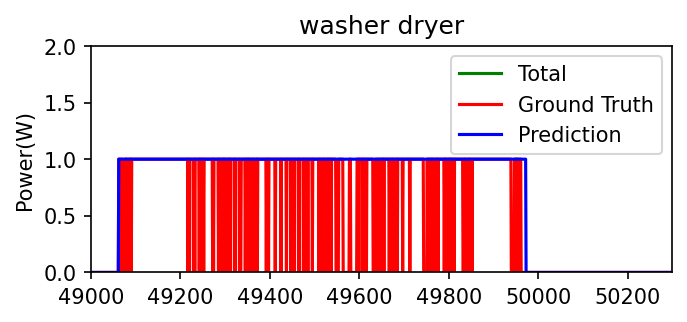

In [56]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall_state['washer dryer'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_state['washer dryer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('washer dryer')
plt.legend()
plt.xlim((49000,50300))
plt.ylim((0,2))

### 2. 负荷分解对比图

(0.0, 3000.0)

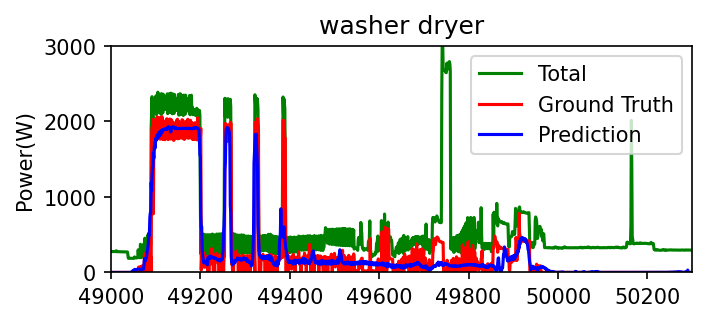

In [57]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall['washer dryer'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall['washer dryer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('washer dryer')
plt.legend()
plt.xlim((49000,50300))
plt.ylim((0,3000))

### 3.降噪后负荷分解对比图

(0.0, 3000.0)

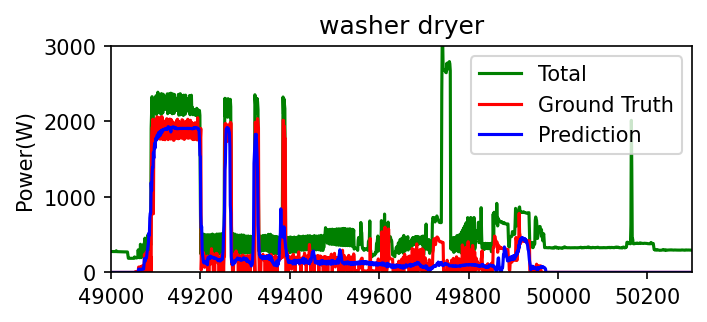

In [58]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall['washer dryer'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_denose['washer dryer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('washer dryer')
plt.legend()
plt.xlim((49000,50300))
plt.ylim((0,3000))

## 2.洗碗机

### 1. 负荷识别对比图

(0.0, 2.0)

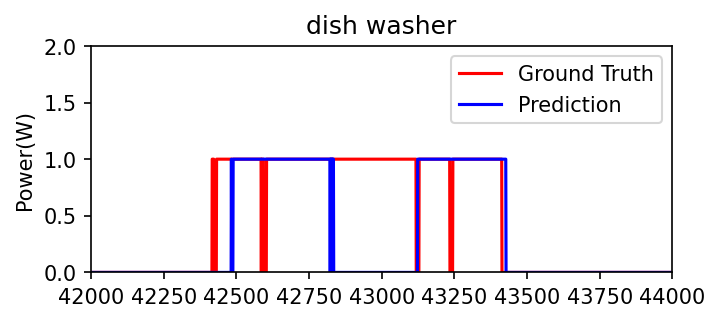

In [59]:
plt.figure(figsize=(5,2),dpi=150)
# plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall_state['dish washer'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_state['dish washer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('dish washer')
plt.legend()
plt.xlim((42000,44000))
plt.ylim((0,2))

### 2. 负荷分解对比图

(0.0, 3000.0)

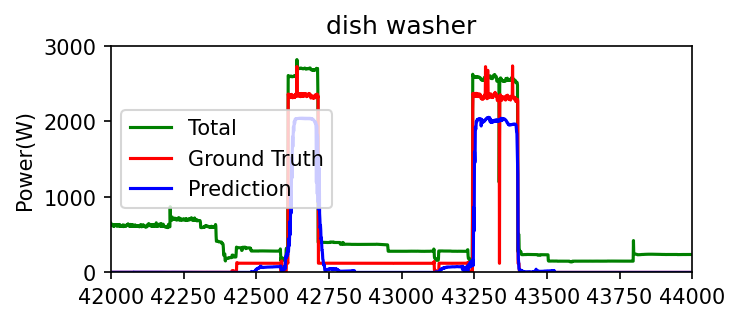

In [60]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall['dish washer'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall['dish washer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('dish washer')
plt.legend()
plt.xlim((42000,44000))
plt.ylim((0,3000))

### 3.降噪后负荷分解对比图

(0.0, 3000.0)

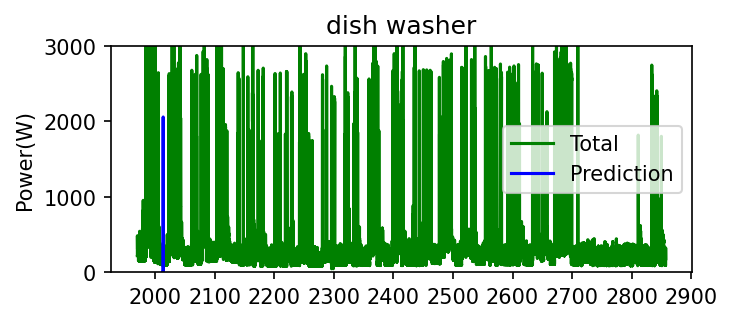

In [61]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
# plt.plot(gt_overall['dish washer'],'-r',label='Ground Truth') 
plt.plot(pred_overall_denose['dish washer'],'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('dish washer')
plt.legend()
# plt.xlim((42000,44000))
plt.ylim((0,3000))

## 3.冰箱

### 1.负荷识别对比图

(0.0, 2.0)

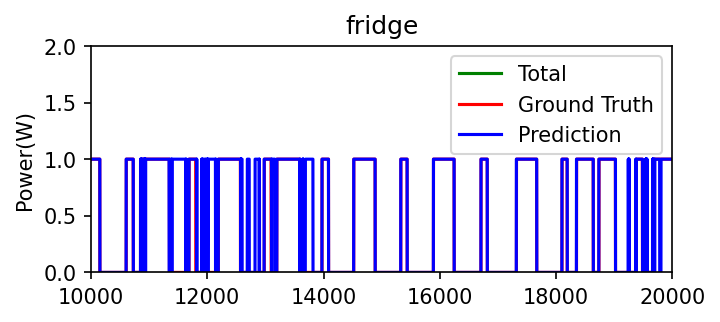

In [63]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall_state['fridge'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_state['fridge'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('fridge')
plt.legend()
plt.xlim((10000,20000))
plt.ylim((0,2))

### 2. 降噪前负荷分解对比图

(0.0, 500.0)

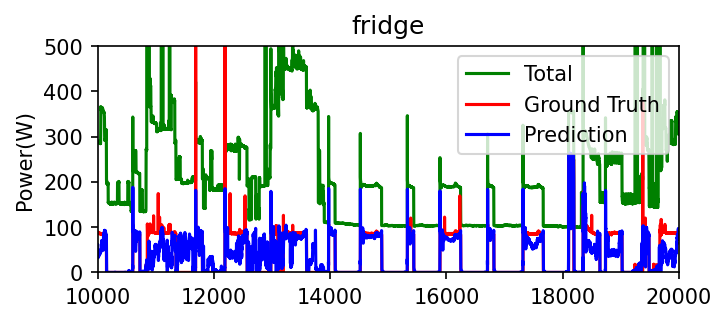

In [64]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall['fridge'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall['fridge'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('fridge')
plt.legend()
plt.xlim((10000,20000))
plt.ylim((0,500))

### 3.降噪后负荷分解对比图

(0.0, 500.0)

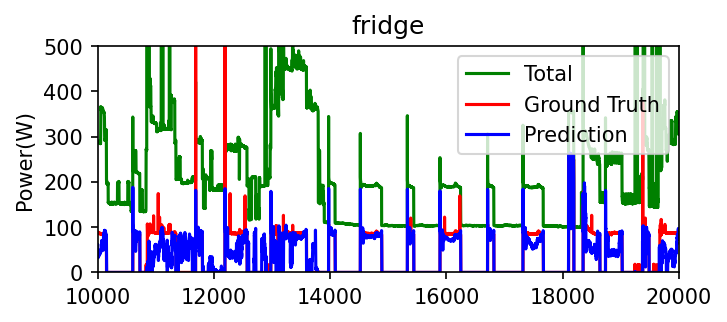

In [65]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall['fridge'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_denose['fridge'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('fridge')
plt.legend()
plt.xlim((10000,20000))
plt.ylim((0,500))

## 4.微波炉

### 1.负荷识别对比图

(0.0, 2.0)

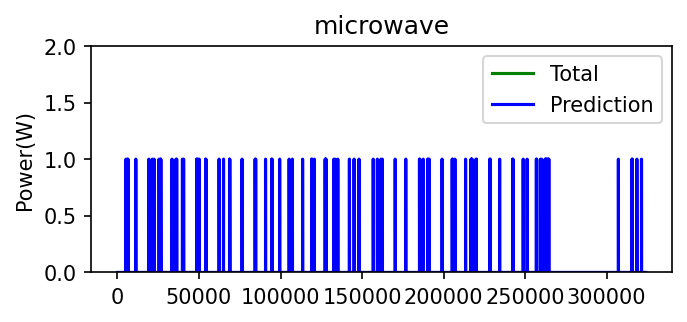

In [66]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
# plt.plot(gt_overall_state['microwave'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_state['microwave'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('microwave')
plt.legend()
# plt.xlim((300000,320000))
plt.ylim((0,2))

### 2.负荷分解对比图

(0.0, 50.0)

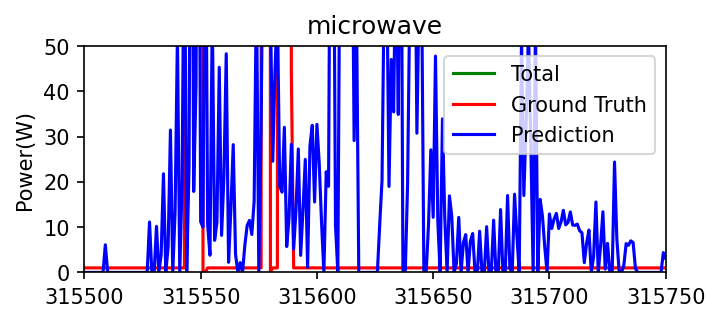

In [67]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall['microwave'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall['microwave'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('microwave')
plt.legend()
plt.xlim((315500,315750))
plt.ylim((0,50))

### 2.降噪后负荷分解对比图

(0.0, 2000.0)

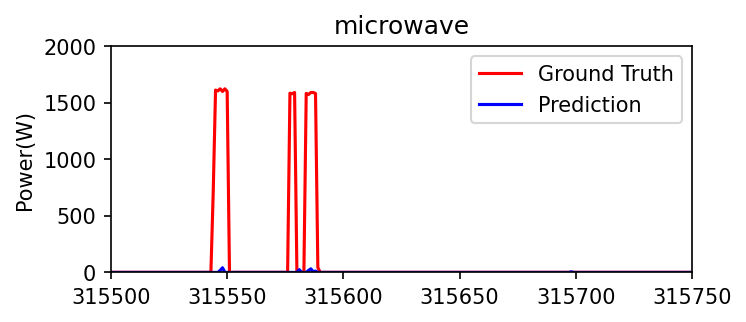

In [68]:
plt.figure(figsize=(5,2),dpi=150)
# plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(gt_overall['microwave'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_denose['microwave'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('microwave')
plt.legend()
plt.xlim((315500,315750))
plt.ylim((0,2000))

## 5.热水壶

### 1.负荷识别对比图

(0.0, 1.5)

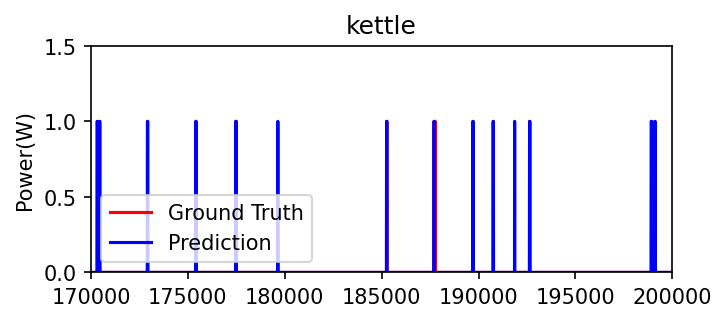

In [69]:
plt.figure(figsize=(5,2),dpi=150)
# plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall_state['kettle'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_state['kettle'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.legend()
plt.title('kettle')
# plt.xlim(61750,62500)
plt.xlim(170000,200000)
plt.ylim(0,1.5)

### 2.负荷分解对比图

(0.0, 40.0)

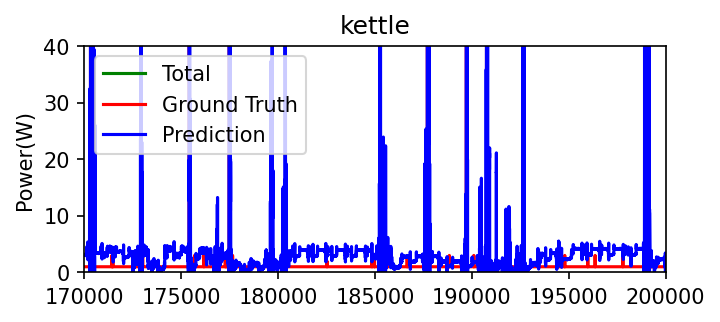

In [70]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall['kettle'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall['kettle'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.legend()
plt.title('kettle')
# plt.xlim(61750,62500)
plt.xlim(170000,200000)
plt.ylim(0,40)

### 3.降噪后负荷分解对比图

(0.0, 40.0)

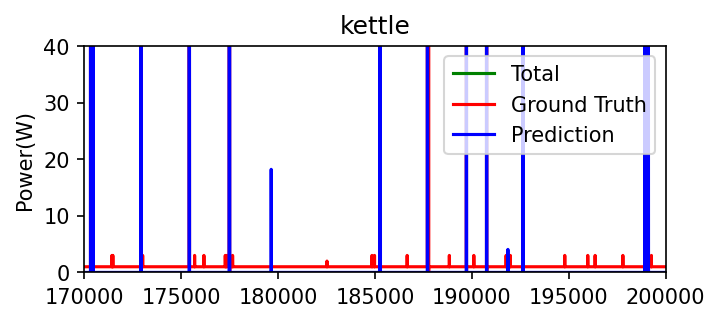

In [71]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'-g',label='Total')
plt.plot(gt_overall['kettle'].values,'-r',label='Ground Truth') 
plt.plot(pred_overall_denose['kettle'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.legend()
plt.title('kettle')
# plt.xlim(61750,62500)
plt.xlim(170000,200000)
plt.ylim(0,40)

# nilmtk-contrib计算

In [442]:
dale = {
  'power': {
            'mains': ['apparent','active'],
            'appliance': ['apparent','active']
            },
  'sample_rate': 6,
  'artificial_aggregate':False,
  'appliances': ['fridge','washer dryer','dish washer','microwave','kettle'],#'washer dryer','dish washer','microwave','kettle']
  'methods': {
             # 'RNN':RNN({'n_epochs':20,'batch_size':256,'sequence_length':99}),
            # "CO":CO({})
              # 'FHMMExacT':FHMMExact({'num_of_states':5})
              'Seq2Point':Seq2Point({'n_epochs':20,'batch_size':1024})
              },
   'train': {    
            'datasets': {
                    'UKDALE': {
                        'path': 'ukdale.h5',
                        'buildings': {
                                        1: {
                                            'start_time':'2013-3-18',
                                            'end_time':'2013-5-18'
                                            }
                                      }
                                }
                        }
            },
	'test': {
            'datasets': {
                        'UKDALE': {
                                'path': 'ukdale.h5',
                                'buildings': {
                                            1: {
                                                'start_time': '2013-5-18',
                                                'end_time': '2013-6-18'
                                                },
                                              }
                                }
                        },
             'metrics':['mae']
            }
}

In [443]:
api=API(dale)

Joint Testing for all algorithms
Loading data for  UKDALE  dataset
Dropping missing values
Generating predictions for : Seq2Point
633/633 [==============================] - 3s 5ms/step
............  mae  ..............
              Seq2Point
fridge        46.817905
washer dryer  69.022789
dish washer   25.135317
microwave     10.792418
kettle        21.004839


In [447]:
api.pred_overall

{'Seq2Point':                                fridge  washer dryer  dish washer  microwave  \
 2013-05-18 00:00:06+01:00   72.148315     12.762848     1.880564   0.877808   
 2013-05-18 00:00:12+01:00  195.706177     18.449837     1.887039   0.877808   
 2013-05-18 00:00:18+01:00  281.300842     27.554817     1.892651   0.877808   
 2013-05-18 00:00:24+01:00  256.610718     18.559984     1.899002   0.877808   
 2013-05-18 00:00:30+01:00  237.018600     18.712585     1.905910   0.877808   
 ...                               ...           ...          ...        ...   
 2013-06-17 23:59:30+01:00   83.247330      0.265804     2.090708   0.877808   
 2013-06-17 23:59:36+01:00   83.367294      0.265804     2.090560   0.877808   
 2013-06-17 23:59:42+01:00   83.495285      0.265804     2.090381   0.877808   
 2013-06-17 23:59:48+01:00   83.572662      0.265804     2.090127   0.877808   
 2013-06-17 23:59:54+01:00   83.625969      0.265804     2.089982   0.877808   
 
                         

# 绘图

## 1.洗衣机

(0.0, 3000.0)

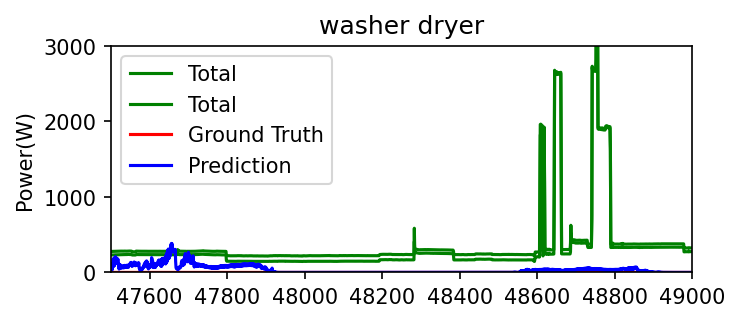

In [444]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(api.test_mains[0].values,'g',label='Total')
plt.plot(api.gt_overall['washer dryer'].values,'-r',label='Ground Truth') 
plt.plot(api.pred_overall['Seq2Point']['washer dryer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('washer dryer')
plt.legend()
plt.xlim((47500,49000))
plt.ylim((0,3000))

## 2.洗碗机

(0.0, 3000.0)

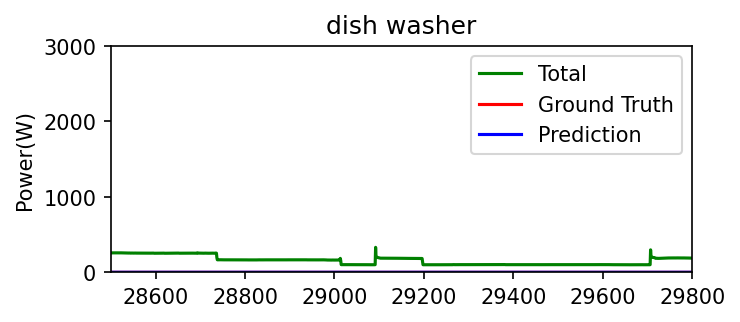

In [445]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(test_mains[0].values,'g',label='Total')
plt.plot(api.gt_overall['dish washer'].values,'-r',label='Ground Truth') 
plt.plot(api.pred_overall['Seq2Point']['dish washer'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('dish washer')
plt.legend()
plt.xlim((28500,29800))
plt.ylim((0,3000))

## 3.冰箱

(0.0, 300.0)

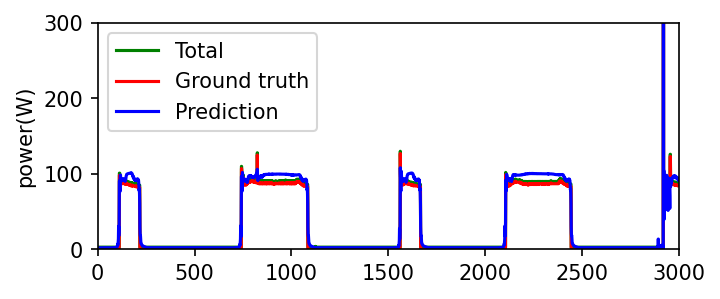

In [393]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(api.test_mains[0].values,'g',label='Total')
plt.plot(api.gt_overall['fridge'].values,'-r',label='Ground truth') 
plt.plot(api.pred_overall['Seq2Point']['fridge'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('power(W)')
plt.legend()
plt.xlim(0,3000)
plt.ylim(0,300)

## 4.微波炉

(0.0, 2000.0)

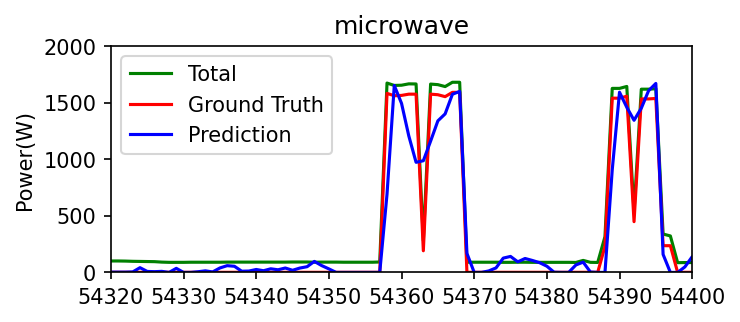

In [277]:
plt.figure(figsize=(5,2),dpi=150)
plt.plot(api.test_mains[0].values,'g',label='Total')
plt.plot(api.gt_overall['microwave'].values,'-r',label='Ground Truth') 
plt.plot(api.pred_overall['Seq2Point']['microwave'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.title('microwave')
plt.legend()
plt.xlim((54320,54400))
plt.ylim((0,2000))

## 5.热水壶

(0.0, 3000.0)

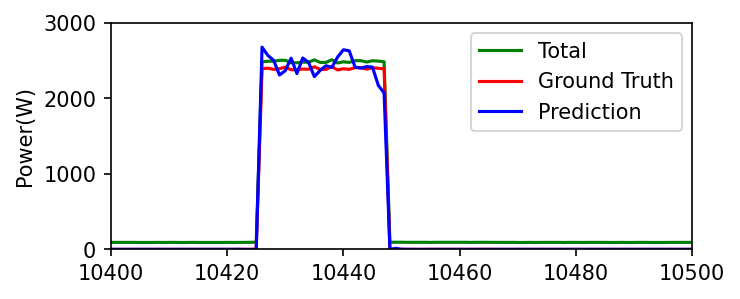

In [275]:
plt.figure(figsize=(5,2),dpi=150)
# plt.rcParams['font.sans-serif'] = ['SimHei']##正常显示中文字体
plt.plot(api.test_mains[0].values,'g',label='Total')
plt.plot(api.gt_overall['kettle'].values,'-r',label='Ground Truth') 
plt.plot(api.pred_overall['Seq2Point']['kettle'].values,'-b',label='Prediction') 
plt.gca().set_ylabel('Power(W)')
plt.legend()
plt.xlim(10400,10500)
plt.ylim(0,3000)

## 评价指标计算

In [392]:
from sklearn import metrics
def metric_mae(test_target,test_predict):
    a=test_predict.sum()
    b=test_target.sum()
    sae=abs(a-b)/b
    return sae
def metric_ea(test_target,test_predict):
    c=np.abs(test_predict-test_target)
    ea=1-c.sum()/(2*test_target.sum())
    return ea
print("......Metrics......")
print("appliance\tMSE\tMAE\tSAE\tEA\t")
for appliance_name in appliances:
    MSE = metrics.mean_squared_error(api.gt_overall[appliance_name].values, api.pred_overall['Seq2Point'][appliance_name])
    MAE = metrics.mean_absolute_error(api.gt_overall[appliance_name].values, api.pred_overall['Seq2Point'][appliance_name])
    SAE=metric_mae(api.gt_overall[appliance_name].values, api.pred_overall['Seq2Point'][appliance_name])
    EA=metric_ea(api.gt_overall[appliance_name].values, api.pred_overall['Seq2Point'][appliance_name].values)
    print("{:12}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t".format(appliance_name,MSE,MAE,SAE,EA))

......Metrics......
appliance	MSE	MAE	SAE	EA	
dish washer 	656.84	4.38	0.04	0.88	
washer dryer	256.63	2.26	0.01	0.96	
microwave   	171.04	1.01	0.07	0.92	
kettle      	485.63	0.82	0.01	0.98	
fridge      	268.17	8.14	0.11	0.89	
